For fine-tuning we have 3 datasets: train, validation and holdout

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn

from scipy.ndimage.interpolation import zoom
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence
import keras.backend as K

from config import *
from utils import specificity, sensitivity, balanced_accuracy, IntensityRescale, sagittal_flip, translate, load_nifti

Using TensorFlow backend.


In [2]:
# Start timing
start_time = time.time()

In [3]:
#percent = 0.5
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = percent
config.gpu_options.visible_device_list = "7"
set_session(tf.Session(config=config))

In [4]:
zero_one_normalize = True
dtype = np.float32
z_factor = 0.525
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/"

In [5]:
!mkdir -p $result_dir

In [6]:
# load hdf5 files and extract columns
train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset.h5', 'r')

X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [7]:
# convert data to numpy arrays
X_train = np.array(X_train, dtype=dtype)
y_train = np.array(y_train)

X_holdout = np.array(X_holdout, dtype=dtype)
y_holdout = np.array(y_holdout)

In [8]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of MS patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


In [9]:
class CISDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        #label = np.array((batch_idx['label'] == "MS")* 1, dtype=np.int8) 
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

## Load mask and reformat

In [10]:
mask_path = "/data/Ritter/MS/Test/total_lesion_mask_blurred.nii.gz"

In [11]:
mask = load_nifti(mask_path, z_factor=z_factor)
mask = np.expand_dims(mask, 4)

/home/fabiane/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


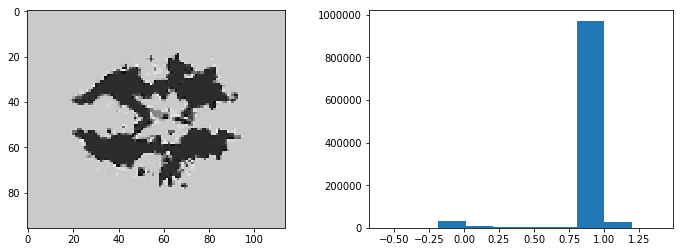

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mask[:,:,48, 0], cmap='gray')
plt.subplot(1, 2, 2)
plt.hist(mask.flatten())
plt.show()

In [13]:
# after zooming return to binary format
mask[np.where(mask>0.5)] = 1.
mask[np.where(mask<=0.5)] = 0.

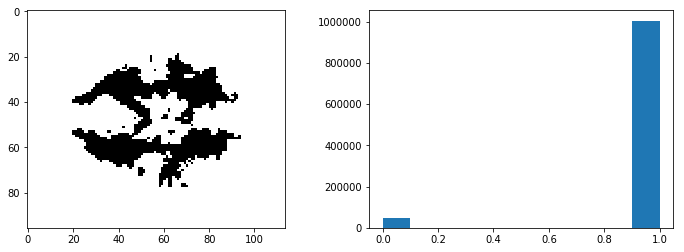

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(mask[:,:,48, 0], cmap='gray')
plt.subplot(1, 2, 2)
plt.hist(mask.flatten())
plt.show()

## Make dataset

In [15]:
intensity = IntensityRescale(masked=False)

In [16]:
if zero_one_normalize:
    cis_data = CISDataset(X_train, y_train, transform=[intensity], batch_size=4, mask=mask)
else:
    cis_data = CISDataset(X_train, y_train, batch_size=4, mask=mask)

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


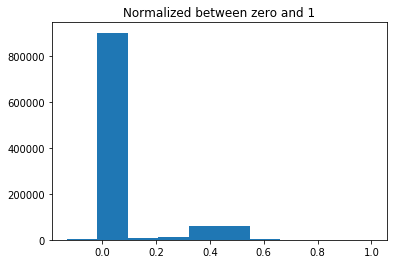

In [17]:
plt.figure()
plt.title("Normalized between zero and 1")
plt.hist(cis_data[4][0][0].flatten())
plt.show()

/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


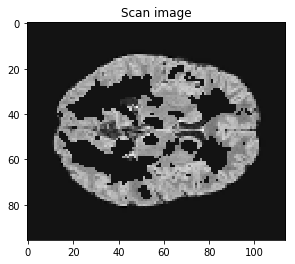

In [18]:
plt.figure()
plt.title("Scan image")
plt.imshow(np.squeeze(cis_data[4][0][0])[:,:,42], cmap='gray')
plt.show()

# Model

In [ ]:
def init_model(path, finetune=True, up_to=7):
    model = load_model(path)
    model.load_weights(path)
    if finetune:
        for layer in model.layers[:up_to]:
            layer.trainable = False
    return model

In [ ]:
# load model weights
#model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model.h5"
model_path = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/model_trial_7.h5"
model = init_model(model_path, finetune=False, up_to=None)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv3D)              (None, 94, 112, 94, 64)   1792      
_________________________________________________________________
Pool_1 (MaxPooling3D)        (None, 31, 37, 31, 64)    0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 31, 37, 31, 64)    0         
_________________________________________________________________
Conv_2 (Conv3D)              (None, 29, 35, 29, 64)    110656    
_________________________________________________________________
Pool_2 (MaxPooling3D)        (None, 9, 11, 9, 64)      0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 9, 11, 9, 64)      0         
_________________________________________________________________
Conv_3 (Conv3D)              (None, 7, 9, 7, 64)       110656    
__________

## Visualization

In [ ]:
def visualize_weights(model):
    # Visualize weights
    W = model.layers[0].get_weights()[0]
    W = np.squeeze(W)[:,:,2]
    print("W shape : ", W.shape)

    print("Weights mean {}".format(W.mean()))
    plt.figure(figsize=(20, 5))
    plt.title('conv1 weights')
    plt.imshow(make_mosaic(W, 2, 2), cmap="gray")
    plt.show()

In [ ]:
import numpy.ma as ma
def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in range(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

In [ ]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)


Pre-trained model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean -0.0022606917191296816


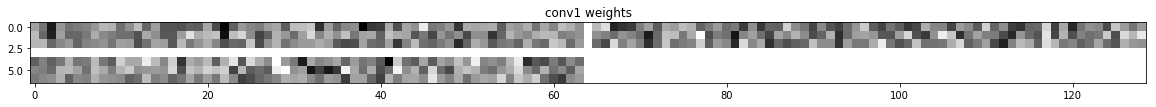

Random model layer 1 weights:
W shape :  (3, 3, 64)
Weights mean 0.0026854847092181444


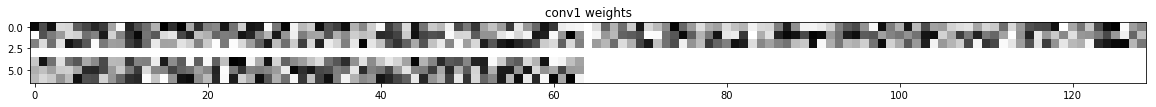

In [ ]:
# Visualize weights
print("Pre-trained model layer 1 weights:")
visualize_weights(model)
model_untrained = load_model(model_path)
reset_weights(model_untrained)
print("Random model layer 1 weights:")
visualize_weights(model_untrained)

## Training

In [ ]:
X_train.shape

(124, 96, 114, 96)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# split training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=77)

In [ ]:
# training args
lr = 0.0005
lr_decay = 0.001
transforms = [intensity, sagittal_flip, translate]

num_trials = 7
store_models = True

# callbacks
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
max_acc = []

for i in range(num_trials):
    print("Trial %i" %i)
    
    # init model
    model = init_model(model_path, finetune=False, up_to=None)    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
    
    # callbacks
    earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')
    if store_models:
        result_path = os.path.join(result_dir, "weights-augm-trial%i-improvement-BEST.hdf5" %i)
        model_checkpoint = ModelCheckpoint(result_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=True)
        callbacks = [earlystop, model_checkpoint]
    else:
        callbacks = [earlystop]
        
    train_loader = CISDataset(X_train, y_train, transform=transforms, batch_size=b, shuffle=True)
    val_loader = CISDataset(X_val, y_val, transform=[intensity], batch_size=1, shuffle=False)
    
    # Start training
    history = model.fit_generator(train_loader,
                        epochs=num_epochs,
                        verbose=1,
                        validation_data=val_loader,
                        callbacks=callbacks)
    
    # Evaluation
    y_pred = model.predict_generator(val_loader)
    #y_true = [item for sublist in [val_loader[batch_idx][1] for batch_idx in range(len(val_loader))] for item in sublist]
    bal_acc = balanced_accuracy(y_val, y_pred>0.5)
    sens = sensitivity(y_val, y_pred>0.5)
    spec = specificity(y_val, y_pred>0.5)
    # Store results
    accuracies.append(history.history["val_acc"][-1])
    balanced_accuracies.append(bal_acc)
    max_acc.append(np.max(history.history["val_acc"]))
    sensitivities.append(sens)
    specificities.append(spec)

training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))

print("Validation final accuracies: \n {}".format(accuracies))
print("Validation final accuracies mean: {}".format(np.mean(accuracies)))
print("Validation best accuracies: \n {}".format(max_acc))
print("Validation best accuracies mean: {}".format(np.mean(max_acc)))
print("Validation balanced accuracies: \n {}".format(balanced_accuracies))
print("Validation balanced accuracies mean: {}".format(np.mean(balanced_accuracies)))
print("Validation final sensitivities: \n {}".format(sensitivities))
print("Validation final sensitivities' mean: {}".format(np.mean(sensitivities)))
print("Validation final specificities: \n {}".format(specificities))
print("Validation final specificities' mean: {}".format(np.mean(specificities)))

Trial 0
Epoch 1/200


/home/fabiane/anaconda2/envs/postal/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()


25/25 [==============================] - 9s 363ms/step - loss: 0.9874 - acc: 0.4302 - val_loss: 0.8922 - val_acc: 0.4400

Epoch 00001: val_acc improved from -inf to 0.44000, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial0-improvement-BEST.hdf5
Epoch 2/200
25/25 [==============================] - 4s 159ms/step - loss: 0.9600 - acc: 0.5066 - val_loss: 0.8793 - val_acc: 0.4400

Epoch 00002: val_acc did not improve from 0.44000
Epoch 3/200
25/25 [==============================] - 4s 168ms/step - loss: 0.9172 - acc: 0.5434 - val_loss: 0.8361 - val_acc: 0.5600

Epoch 00003: val_acc improved from 0.44000 to 0.56000, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/lesions_removed_blurred/weights-augm-trial0-improvement-BEST.hdf5
Epoch 4/200
25/25 [==============================] - 4s 171ms/step - loss: 0.8925 - acc: 0.4566 - val_loss: 0.8646 - val_acc: 0.4400

Epoch 00004: val_acc did no


Epoch 00040: val_acc did not improve from 0.88000
Epoch 41/200
25/25 [==============================] - 4s 160ms/step - loss: 0.3350 - acc: 0.9400 - val_loss: 0.5704 - val_acc: 0.7600

Epoch 00041: val_acc did not improve from 0.88000
Epoch 42/200
25/25 [==============================] - 4s 164ms/step - loss: 0.2737 - acc: 0.9600 - val_loss: 0.5347 - val_acc: 0.8400

Epoch 00042: val_acc did not improve from 0.88000
Epoch 43/200
25/25 [==============================] - 4s 162ms/step - loss: 0.2587 - acc: 0.9700 - val_loss: 0.5984 - val_acc: 0.7600

Epoch 00043: val_acc did not improve from 0.88000
Epoch 44/200
25/25 [==============================] - 4s 167ms/step - loss: 0.2637 - acc: 0.9900 - val_loss: 0.5420 - val_acc: 0.8000

Epoch 00044: val_acc did not improve from 0.88000
Epoch 45/200
25/25 [==============================] - 4s 165ms/step - loss: 0.2741 - acc: 0.9600 - val_loss: 0.5762 - val_acc: 0.8000

Epoch 00045: val_acc did not improve from 0.88000
Epoch 46/200
25/25 [====

25/25 [==============================] - 4s 160ms/step - loss: 0.3813 - acc: 0.9300 - val_loss: 0.5637 - val_acc: 0.7600

Epoch 00029: val_acc did not improve from 0.84000
Epoch 30/200
25/25 [==============================] - 4s 178ms/step - loss: 0.3865 - acc: 0.9200 - val_loss: 0.5382 - val_acc: 0.7600

Epoch 00030: val_acc did not improve from 0.84000
Epoch 31/200
25/25 [==============================] - 4s 160ms/step - loss: 0.3517 - acc: 0.9400 - val_loss: 0.6213 - val_acc: 0.7600

Epoch 00031: val_acc did not improve from 0.84000
Epoch 32/200
25/25 [==============================] - 4s 170ms/step - loss: 0.4001 - acc: 0.9400 - val_loss: 0.4953 - val_acc: 0.8000

Epoch 00032: val_acc did not improve from 0.84000
Epoch 33/200
25/25 [==============================] - 4s 170ms/step - loss: 0.3669 - acc: 0.9300 - val_loss: 0.6688 - val_acc: 0.7200

Epoch 00033: val_acc did not improve from 0.84000
Epoch 34/200
25/25 [==============================] - 4s 168ms/step - loss: 0.3126 - acc

25/25 [==============================] - 4s 168ms/step - loss: 0.5613 - acc: 0.8367 - val_loss: 0.6568 - val_acc: 0.6400

Epoch 00016: val_acc did not improve from 0.76000
Epoch 17/200
25/25 [==============================] - 4s 168ms/step - loss: 0.5681 - acc: 0.7799 - val_loss: 0.7222 - val_acc: 0.6000

Epoch 00017: val_acc did not improve from 0.76000
Epoch 18/200
25/25 [==============================] - 4s 164ms/step - loss: 0.5210 - acc: 0.8667 - val_loss: 0.6085 - val_acc: 0.7600

Epoch 00018: val_acc did not improve from 0.76000
Epoch 19/200
25/25 [==============================] - 4s 166ms/step - loss: 0.5135 - acc: 0.8335 - val_loss: 0.6142 - val_acc: 0.7200

Epoch 00019: val_acc did not improve from 0.76000
Epoch 20/200
25/25 [==============================] - 4s 165ms/step - loss: 0.4816 - acc: 0.8267 - val_loss: 0.6253 - val_acc: 0.8000

Epoch 00020: val_acc improved from 0.76000 to 0.80000, saving model to /analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/les

25/25 [==============================] - 4s 170ms/step - loss: 0.6360 - acc: 0.7567 - val_loss: 0.6050 - val_acc: 0.8000

Epoch 00012: val_acc did not improve from 0.88000
Epoch 13/200
25/25 [==============================] - 4s 166ms/step - loss: 0.6303 - acc: 0.7699 - val_loss: 0.6089 - val_acc: 0.8000

Epoch 00013: val_acc did not improve from 0.88000
Epoch 14/200
25/25 [==============================] - 4s 161ms/step - loss: 0.5782 - acc: 0.8800 - val_loss: 0.6067 - val_acc: 0.8000

Epoch 00014: val_acc did not improve from 0.88000
Epoch 15/200
25/25 [==============================] - 4s 162ms/step - loss: 0.5305 - acc: 0.8399 - val_loss: 0.5900 - val_acc: 0.8400

Epoch 00015: val_acc did not improve from 0.88000
Epoch 16/200
25/25 [==============================] - 4s 165ms/step - loss: 0.4901 - acc: 0.8499 - val_loss: 0.6096 - val_acc: 0.8000

Epoch 00016: val_acc did not improve from 0.88000
Epoch 17/200
25/25 [==============================] - 4s 168ms/step - loss: 0.4591 - acc

25/25 [==============================] - 4s 159ms/step - loss: 0.7151 - acc: 0.6767 - val_loss: 0.6879 - val_acc: 0.7200

Epoch 00012: val_acc did not improve from 0.80000
Epoch 13/200
25/25 [==============================] - 4s 166ms/step - loss: 0.6493 - acc: 0.7999 - val_loss: 0.6378 - val_acc: 0.8000

Epoch 00013: val_acc did not improve from 0.80000
Epoch 14/200
25/25 [==============================] - 4s 162ms/step - loss: 0.6238 - acc: 0.7767 - val_loss: 0.6203 - val_acc: 0.7600

Epoch 00014: val_acc did not improve from 0.80000
Epoch 15/200
25/25 [==============================] - 4s 165ms/step - loss: 0.5653 - acc: 0.8399 - val_loss: 0.6151 - val_acc: 0.8000

Epoch 00015: val_acc did not improve from 0.80000
Epoch 16/200
25/25 [==============================] - 4s 161ms/step - loss: 0.5239 - acc: 0.8367 - val_loss: 0.6351 - val_acc: 0.6800

Epoch 00016: val_acc did not improve from 0.80000
Epoch 17/200
25/25 [==============================] - 4s 158ms/step - loss: 0.5445 - acc

In [ ]:
training_time = time.time() - start_time

# Evaluation

In [ ]:
weights = ["weights-augm-trial%i-improvement-BEST.hdf5"%i for i in range(num_trials)]

In [ ]:
# load holdout set
test_loader = CISDataset(X_holdout, y_holdout, transform=[intensity], batch_size=1, shuffle=False, mask=mask)

In [ ]:
accuracies = []
balanced_accuracies = []
sensitivities = []
specificities = []
for fold, weight in enumerate(weights):
    print("Fold {}".format(fold))
    model = load_model(model_path)
    model_dir = os.path.join(result_dir, weight)
    model.load_weights(model_dir)
    
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(optimizer=opti,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    # Evaluate
    res = model.evaluate_generator(test_loader)
    y_pred = model.predict_generator(test_loader)
    bal_acc = balanced_accuracy(y_holdout, y_pred>0.5)
    sens = sensitivity(y_holdout, y_pred>0.5)
    spec = specificity(y_holdout, y_pred>0.5)
    # Store results
    accuracies.append(res[1])
    balanced_accuracies.append(bal_acc)
    sensitivities.append(sens)
    specificities.append(spec)
    # Print results
    print("Model accuracy {:.2f} %".format(res[1]*100))
    print("Balanced accuracy {:.2f} %".format(bal_acc*100))
    print("Sensitivity {:.2f} %".format(sens*100))
    print("Specificity {:.2f} %".format(spec*100))
    
    
print("######## Final results ########")
print("Accuracy mean {:.2f} %".format(np.mean(accuracies)*100))
print("Balanced accuracy mean {:.2f} %".format(np.mean(balanced_accuracies)*100))
print("Sensitivity mean {:.2f} %".format(np.mean(sensitivities)*100))
print("Specificity mean {:.2f} %".format(np.mean(specificities)*100))

In [ ]:
total_time = time.time() - start_time

In [ ]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
print("Total time elapsed: {}h:{}m:{}s".format(
            total_time//3600, (total_time//60)%60, total_time%60))

In [ ]:
quit()